In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob

In [2]:
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

DATA_FOLDER = 'C:/Users/pc/Desktop/road/512/'
SAVE_FOLDER = 'C:/Users/pc/Desktop/road'

train_img_list = np.array(glob(os.path.join(DATA_FOLDER + '*/*.jpg')))

In [3]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

NUM_IMAGES = len(train_img_list)
print(NUM_IMAGES)

mode =  'build'

1186


In [4]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 1186 images belonging to 1 classes.


In [5]:
class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

In [6]:
z_dim = 200
r_loss_factor = 10000

# encoder model definition

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['encoder_conv_0[0][0]']         
 alization)                                                                                       
                                                                                            

In [7]:
# decoder model definition

decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_t0 (Conv2DTran  (None, 16, 16, 64)       36928     
 spose)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0   

In [8]:
# Variational Autoencoder model definition

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                #tf.square(data - reconstruction)
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        _,_,latent = self.encoder(inputs)
        return self.decoder(latent)

In [9]:
LEARNING_RATE = 0.0005
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

save_folder = os.path.join(SAVE_FOLDER, 'weights')

VAE = VAEModel(encoder, decoder)
VAE.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [10]:
MODE = 'build'
#MODE = 'load'

if MODE == 'load':
    #ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    VAE.load_weights(save_folder+'/'+'checkpoint')

In [11]:
# train

def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint{epoch:03d}/', save_weights_only = True, verbose=1)
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=1, step_size=1)
callbacks_list = [checkpoint, lr_sched]

VAE.fit(
    data_flow,
    shuffle=True,
    epochs=EPOCHS,
    steps_per_epoch = NUM_IMAGES / BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/200
38/37 [==============================] - ETA: 0s - loss: 6835.3404 - reconstruction_loss: 6829.5911 - kl_loss: 5.7494
Epoch 1: saving model to C:/Users/pc/Desktop/road\weights/checkpoint001\
37/37 [==============================] - 8s 159ms/step - loss: 6831.1497 - reconstruction_loss: 6825.2750 - kl_loss: 5.8747 - lr: 5.0000e-04
Epoch 2/200
38/37 [==============================] - ETA: 0s - loss: 6515.4368 - reconstruction_loss: 6494.9807 - kl_loss: 20.4561
Epoch 2: saving model to C:/Users/pc/Desktop/road\weights/checkpoint002\
37/37 [==============================] - 5s 138ms/step - loss: 6516.0383 - reconstruction_loss: 6495.5602 - kl_loss: 20.4782 - lr: 5.0000e-04
Epoch 3/200
38/37 [==============================] - ETA: 0s - loss: 6450.9061 - reconstruction_loss: 6431.0134 - kl_loss: 19.8927
Epoch 3: saving model to C:/Users/pc/Desktop/road\weights/checkpoint003\
37/37 [==============================] - 5s 133ms/step - loss: 6451.8449 - reconstruction_loss: 6432.0886 

Epoch 25/200
37/37 [============================>.] - ETA: 0s - loss: 6396.6034 - reconstruction_loss: 6381.8669 - kl_loss: 14.7365
Epoch 25: saving model to C:/Users/pc/Desktop/road\weights/checkpoint025\
37/37 [==============================] - 5s 132ms/step - loss: 6388.5039 - reconstruction_loss: 6373.8616 - kl_loss: 14.6423 - lr: 5.0000e-04
Epoch 26/200
38/37 [==============================] - ETA: 0s - loss: 6406.5333 - reconstruction_loss: 6392.0332 - kl_loss: 14.5001
Epoch 26: saving model to C:/Users/pc/Desktop/road\weights/checkpoint026\
37/37 [==============================] - 6s 145ms/step - loss: 6405.1623 - reconstruction_loss: 6390.6569 - kl_loss: 14.5054 - lr: 5.0000e-04
Epoch 27/200
37/37 [============================>.] - ETA: 0s - loss: 6391.6724 - reconstruction_loss: 6377.7163 - kl_loss: 13.9561
Epoch 27: saving model to C:/Users/pc/Desktop/road\weights/checkpoint027\
37/37 [==============================] - 6s 164ms/step - loss: 6384.6403 - reconstruction_loss: 63

Epoch 49/200
38/37 [==============================] - ETA: 0s - loss: 6386.7933 - reconstruction_loss: 6378.4196 - kl_loss: 8.3737
Epoch 49: saving model to C:/Users/pc/Desktop/road\weights/checkpoint049\
37/37 [==============================] - 7s 179ms/step - loss: 6385.8126 - reconstruction_loss: 6377.4261 - kl_loss: 8.3865 - lr: 5.0000e-04
Epoch 50/200
38/37 [==============================] - ETA: 0s - loss: 6393.0557 - reconstruction_loss: 6384.5651 - kl_loss: 8.4906
Epoch 50: saving model to C:/Users/pc/Desktop/road\weights/checkpoint050\
37/37 [==============================] - 8s 220ms/step - loss: 6394.1440 - reconstruction_loss: 6385.6627 - kl_loss: 8.4813 - lr: 5.0000e-04
Epoch 51/200
38/37 [==============================] - ETA: 0s - loss: 6381.7985 - reconstruction_loss: 6373.3860 - kl_loss: 8.4125
Epoch 51: saving model to C:/Users/pc/Desktop/road\weights/checkpoint051\
37/37 [==============================] - 7s 197ms/step - loss: 6378.7559 - reconstruction_loss: 6370.34

Epoch 73/200
38/37 [==============================] - ETA: 0s - loss: 6359.6125 - reconstruction_loss: 6353.0039 - kl_loss: 6.6086
Epoch 73: saving model to C:/Users/pc/Desktop/road\weights/checkpoint073\
37/37 [==============================] - 7s 176ms/step - loss: 6360.8864 - reconstruction_loss: 6354.2751 - kl_loss: 6.6113 - lr: 5.0000e-04
Epoch 74/200
38/37 [==============================] - ETA: 0s - loss: 6361.0100 - reconstruction_loss: 6354.4188 - kl_loss: 6.5911
Epoch 74: saving model to C:/Users/pc/Desktop/road\weights/checkpoint074\
37/37 [==============================] - 6s 153ms/step - loss: 6362.8042 - reconstruction_loss: 6356.2115 - kl_loss: 6.5928 - lr: 5.0000e-04
Epoch 75/200
38/37 [==============================] - ETA: 0s - loss: 6375.6886 - reconstruction_loss: 6369.0973 - kl_loss: 6.5913
Epoch 75: saving model to C:/Users/pc/Desktop/road\weights/checkpoint075\
37/37 [==============================] - 6s 162ms/step - loss: 6370.9525 - reconstruction_loss: 6364.34

Epoch 97/200
38/37 [==============================] - ETA: 0s - loss: 6377.6989 - reconstruction_loss: 6371.1811 - kl_loss: 6.5178
Epoch 97: saving model to C:/Users/pc/Desktop/road\weights/checkpoint097\
37/37 [==============================] - 6s 155ms/step - loss: 6375.5224 - reconstruction_loss: 6368.9963 - kl_loss: 6.5261 - lr: 5.0000e-04
Epoch 98/200
38/37 [==============================] - ETA: 0s - loss: 6364.0882 - reconstruction_loss: 6357.4493 - kl_loss: 6.6389
Epoch 98: saving model to C:/Users/pc/Desktop/road\weights/checkpoint098\
37/37 [==============================] - 6s 157ms/step - loss: 6367.7787 - reconstruction_loss: 6361.1681 - kl_loss: 6.6106 - lr: 5.0000e-04
Epoch 99/200
38/37 [==============================] - ETA: 0s - loss: 6378.8987 - reconstruction_loss: 6372.2512 - kl_loss: 6.6475
Epoch 99: saving model to C:/Users/pc/Desktop/road\weights/checkpoint099\
37/37 [==============================] - 6s 147ms/step - loss: 6380.5594 - reconstruction_loss: 6373.92

37/37 [==============================] - 7s 188ms/step - loss: 6387.1832 - reconstruction_loss: 6380.8435 - kl_loss: 6.3397 - lr: 5.0000e-04
Epoch 121/200
38/37 [==============================] - ETA: 0s - loss: 6370.0242 - reconstruction_loss: 6363.6852 - kl_loss: 6.3391
Epoch 121: saving model to C:/Users/pc/Desktop/road\weights/checkpoint121\
37/37 [==============================] - 8s 224ms/step - loss: 6369.4110 - reconstruction_loss: 6363.0742 - kl_loss: 6.3369 - lr: 5.0000e-04
Epoch 122/200
38/37 [==============================] - ETA: 0s - loss: 6383.9822 - reconstruction_loss: 6377.5470 - kl_loss: 6.4352
Epoch 122: saving model to C:/Users/pc/Desktop/road\weights/checkpoint122\
37/37 [==============================] - 7s 175ms/step - loss: 6385.8464 - reconstruction_loss: 6379.4237 - kl_loss: 6.4227 - lr: 5.0000e-04
Epoch 123/200
38/37 [==============================] - ETA: 0s - loss: 6379.8933 - reconstruction_loss: 6373.5133 - kl_loss: 6.3799
Epoch 123: saving model to C:/U

38/37 [==============================] - ETA: 0s - loss: 6375.9639 - reconstruction_loss: 6369.4662 - kl_loss: 6.4978
Epoch 144: saving model to C:/Users/pc/Desktop/road\weights/checkpoint144\
37/37 [==============================] - 7s 178ms/step - loss: 6376.6423 - reconstruction_loss: 6370.1588 - kl_loss: 6.4835 - lr: 5.0000e-04
Epoch 145/200
38/37 [==============================] - ETA: 0s - loss: 6384.7356 - reconstruction_loss: 6378.3142 - kl_loss: 6.4214
Epoch 145: saving model to C:/Users/pc/Desktop/road\weights/checkpoint145\
37/37 [==============================] - 6s 150ms/step - loss: 6386.4703 - reconstruction_loss: 6380.0617 - kl_loss: 6.4086 - lr: 5.0000e-04
Epoch 146/200
38/37 [==============================] - ETA: 0s - loss: 6349.2417 - reconstruction_loss: 6342.6825 - kl_loss: 6.5592
Epoch 146: saving model to C:/Users/pc/Desktop/road\weights/checkpoint146\
37/37 [==============================] - 5s 145ms/step - loss: 6348.6680 - reconstruction_loss: 6342.0890 - kl_

37/37 [==============================] - 6s 169ms/step - loss: 6279.6807 - reconstruction_loss: 6273.1613 - kl_loss: 6.5194 - lr: 5.0000e-04
Epoch 168/200
38/37 [==============================] - ETA: 0s - loss: 6369.7064 - reconstruction_loss: 6363.1549 - kl_loss: 6.5515
Epoch 168: saving model to C:/Users/pc/Desktop/road\weights/checkpoint168\
37/37 [==============================] - 6s 153ms/step - loss: 6371.8620 - reconstruction_loss: 6365.3152 - kl_loss: 6.5468 - lr: 5.0000e-04
Epoch 169/200
38/37 [==============================] - ETA: 0s - loss: 6342.8677 - reconstruction_loss: 6336.2939 - kl_loss: 6.5738
Epoch 169: saving model to C:/Users/pc/Desktop/road\weights/checkpoint169\
37/37 [==============================] - 6s 159ms/step - loss: 6343.5896 - reconstruction_loss: 6337.0297 - kl_loss: 6.5598 - lr: 5.0000e-04
Epoch 170/200
38/37 [==============================] - ETA: 0s - loss: 6374.2183 - reconstruction_loss: 6367.8294 - kl_loss: 6.3889
Epoch 170: saving model to C:/U

38/37 [==============================] - ETA: 0s - loss: 6377.1429 - reconstruction_loss: 6369.8554 - kl_loss: 7.2876
Epoch 191: saving model to C:/Users/pc/Desktop/road\weights/checkpoint191\
37/37 [==============================] - 6s 164ms/step - loss: 6379.4616 - reconstruction_loss: 6372.2057 - kl_loss: 7.2559 - lr: 5.0000e-04
Epoch 192/200
38/37 [==============================] - ETA: 0s - loss: 6366.0133 - reconstruction_loss: 6358.8331 - kl_loss: 7.1802
Epoch 192: saving model to C:/Users/pc/Desktop/road\weights/checkpoint192\
37/37 [==============================] - 7s 174ms/step - loss: 6368.9351 - reconstruction_loss: 6361.7884 - kl_loss: 7.1468 - lr: 5.0000e-04
Epoch 193/200
38/37 [==============================] - ETA: 0s - loss: 6381.0076 - reconstruction_loss: 6373.9419 - kl_loss: 7.0657
Epoch 193: saving model to C:/Users/pc/Desktop/road\weights/checkpoint193\
37/37 [==============================] - 6s 164ms/step - loss: 6383.6140 - reconstruction_loss: 6376.5484 - kl_

In [15]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

x = np.random.rand(1,128,128,3)
VAE.predict(x)
#VAE.save(save_folder)
tf.saved_model.save(VAE, save_folder)

1/1 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: C:/Users/pc/Desktop/road\weights\assets


INFO:tensorflow:Assets written to: C:/Users/pc/Desktop/road\weights\assets


In [13]:
VAE.load_weights('C:/Users/pc/Desktop/road/weights/checkpoint200/')

1/1 [==============================] - 1s 655ms/step


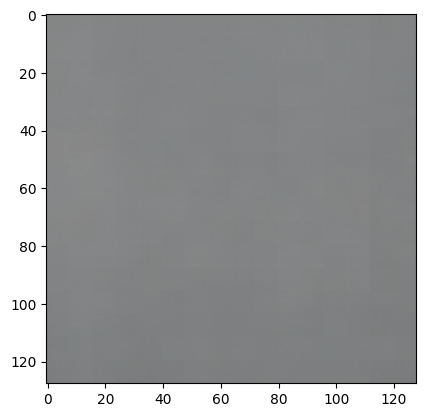

In [14]:
x = np.random.rand(1,128,128,3)
#plt.imshow(x[0])
plt.imshow(VAE.predict(x)[0])